In [1]:
#!pip install -U transformers
#!pip install -U datasets
#!pip install optuna
import os
import sys
HOME = os.path.abspath('..')
sys.path.append(HOME)
os.chdir(HOME)
import pandas as pd
#!pip install transformers
from transformers import RobertaConfig, RobertaModel,RobertaForSequenceClassification, Trainer,AutoModelForSequenceClassification, EarlyStoppingCallback 
from transformers import AutoTokenizer
from transformers.models.roberta import RobertaPreTrainedModel
import torch
from torch import nn
from transformers import TrainingArguments
import glob
import optuna
from itertools import product
import numpy as np
from pprint import pprint
import csv
from transformers import set_seed

In [2]:
MODEL_NAME =  "distilbert-base-uncased" #"roberta-base" 
TARGET_COL = 'averageRating'#'revenue_worldwide_BOM'
MODEL_FOLDER = 'everything_as_text_except_numbers'#'everything_as_text'
text_input_col = 'text_input'
CATEGORIES_AS_TEXT = True
NUMERIC_AS_TEXT = False
DATE_AS_TEXT = False
ADJUST_INFLATION = False
USE_COLUMN_NAMES = False
COLAB = False
DEBUG = False

FINAL_MODEL_NAME = f"{MODEL_NAME}-{TARGET_COL}"

if ADJUST_INFLATION:
    FINAL_MODEL_NAME+='-inflation_adjusted'
    
if USE_COLUMN_NAMES:
    FINAL_MODEL_NAME+='-with_column_names'
    

FINAL_MODEL_PATH = f'models/{MODEL_FOLDER}/{FINAL_MODEL_NAME}'
TRIALS_DF_PATH = f'models/{MODEL_FOLDER}/{FINAL_MODEL_NAME}_hparams_trials.csv'
TEST_PERFORMANCE_PATH = f'models/{MODEL_FOLDER}/{FINAL_MODEL_NAME}_test_stats_best_model.csv'
    
if USE_COLUMN_NAMES:
    assert CATEGORIES_AS_TEXT|NUMERIC_AS_TEXT|DATE_AS_TEXT, "can't use column names as text if there are no columns to treat as text!"
    
print('Final model name: ',FINAL_MODEL_NAME)
print('Saving at: ',MODEL_FOLDER)


if COLAB == True:
  if not os.path.exists('data'):
    os.mkdir('data')
  if not os.path.exists('data/processed'):
    os.mkdir('data/processed')

  drive.mount('/content/gdrive/')
  for filename in glob.glob(os.path.join('gdrive/MyDrive/atdl', '*.*')):
      shutil.copy(filename, 'data/processed')
    


Final model name:  distilbert-base-uncased-averageRating
Saving at:  everything_as_text_except_numbers


In [3]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

def process_text_data(data_:pd.DataFrame,text_col,padding ="max_length", truncation = True, na_filler = ""):

    '''
    
    '''
    data = data_.copy()
    data[text_col] = data[text_col].fillna(na_filler)
    encodings = tokenizer(data[text_col].tolist(), padding=padding, truncation=truncation)
    return encodings
    

def columns_to_single_text(df,cols_to_transform,new_col_name = 'text_input',sep = tokenizer.sep_token,nan_replacement = tokenizer.unk_token ):

  '''
  
  Creates a new column called new_col_name with with all columns in cols_to_transform concatenated into a single text
  '''
  df[new_col_name] = df[cols_to_transform].astype(str).replace('nan',nan_replacement).agg(f' {sep} '.join, axis=1)


class NAFiller:

  def __init__(self,train):
    self.train = train

  def fit(self,column = 'Budget',groupby=['top_genre','top_country']):
    self.mapping = self.train.groupby(groupby)[column].median().reset_index()
    self.mapping = self.mapping.rename(columns={column:'na_filler'})
    self.median = self.train[column].median()
    self.column=column


  def transform(self,test,round = False):
    self.na_filler = test.merge(self.mapping,how='left')['na_filler']
    self.na_filler = self.na_filler.fillna(self.median)

    test[self.column] = test[self.column].reset_index(drop=True).fillna(self.na_filler).values

    if round:
      test[self.column] = test[self.column].round().astype(int)
      


  def fit_transform(self,test,column = 'Budget',groupby=['top_genre','top_country']):
    self.fit(column,groupby)
    self.transform()
    self.column=column
        

def create_dataset_split(split,text_cols,text_input_col,TARGET_COL,numeric_cols = [],images = None):
    
  if TARGET_COL == 'revenue_worldwide_BOM':
    split[TARGET_COL] = np.log1p(split[TARGET_COL])
    print('log transforming target')

  #If all columns in text_cols are combined into a single text. A n
  columns_to_single_text(split,text_cols)

  #Get split encodings
  split_encodings = process_text_data(split,text_input_col)
    
  #split_encodings['numeric_features'] = None
  #split_encodings['images'] = None
    
  if numeric_cols:
    split_encodings['numeric_features'] = split[numeric_cols].values.tolist()
    
  #get labels
  split_labels = split[TARGET_COL].tolist()

  #Create dataset objects
  split_dataset = IMDbDataset(split_encodings, split_labels)

  return split_dataset


def get_model():
    return get_model_by_name(MODEL_NAME)

def get_model_by_name(model_name):
    return AutoModelForSequenceClassification.from_pretrained(model_name,
                                                         problem_type='regression',
                                                         num_labels=1
                                                        )       

def date_to_season(doy):
    doy = doy.dayofyear
    # "day of year" ranges for the northern hemisphere
    spring = range(80, 172)
    summer = range(172, 264)
    fall = range(264, 355)
    # winter = everything else

    if doy in spring:
      season = 1 #'spring'
    elif doy in summer:
      season = 2 #'summer'
    elif doy in fall:
      season = 3 #'fall'
    else:
      season = 4 #'winter'
    return season

In [4]:
from typing import Dict, List, Optional, Set, Tuple, Union

In [5]:
from transformers.models.distilbert import DistilBertConfig

In [6]:
all_cols =  ['Budget',
             'averageRating',
             'cast',
             'countries',
             'director',
             'genres',
             'imdb_id',
             'languages',
             'overview',
             'production companies',
             'release_date',
             'revenue_worldwide_BOM',
             'runtimeMinutes',
             'title']

train_ids = pd.read_csv('data/processed/train.csv',usecols=['imdb_id'])['imdb_id'].tolist()
val_ids = pd.read_csv('data/processed/val.csv',usecols=['imdb_id'])['imdb_id'].tolist()
test_ids = pd.read_csv('data/processed/test.csv',usecols=['imdb_id'])['imdb_id'].tolist()
df = pd.read_csv('data/processed/df.csv',usecols = all_cols,parse_dates=['release_date']).sample(frac=1,random_state=42) #shuffle


#Additional auxilary columns
df['top_genre'] = df['genres'].apply(lambda x: x.split(', ')[0])
df['top_country'] = df['countries'].apply(lambda x: x.split(', ')[0] if isinstance(x,str) else x)

df['year'] = df['release_date'].dt.year
df['month'] = df['release_date'].dt.month
df['day'] = df['release_date'].dt.day
df['season'] = df['release_date'].apply(date_to_season)
df['dayofweek'] = df['release_date'].dt.dayofweek




categoric_cols = ['cast',
                  'countries',
                  'director',
                  'genres',
                  'languages',
                  'production companies']

text_cols = ['title','overview']                  
date_cols = ['release_date']
numeric_cols = ['Budget',
                'runtimeMinutes'
               ] 

if (not DATE_AS_TEXT): #If date is not as text, include numeri date features
    numeric_cols += ['year',
                     'month',
                     'day',
                     'season',
                     'dayofweek']

                

if CATEGORIES_AS_TEXT:
  text_cols+=categoric_cols

if NUMERIC_AS_TEXT:
  text_cols+=numeric_cols

if DATE_AS_TEXT:
  text_cols+=date_cols


df[categoric_cols] = df[categoric_cols].apply(lambda x: x.str.replace('|',', '),axis=0) #Change pipe to comma, its more meaningful

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:67: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [7]:
df['runtimeMinutes'] = pd.to_numeric(df['runtimeMinutes'],errors='coerce')

In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
#Create splits
if DEBUG:
    train = df[df['imdb_id'].isin(train_ids)].sample(frac=0.2)
    val = df[df['imdb_id'].isin(val_ids)].sample(frac=0.2)
    test = df[df['imdb_id'].isin(test_ids)]
else:
    train = df[df['imdb_id'].isin(train_ids)]
    val = df[df['imdb_id'].isin(val_ids)]
    test = df[df['imdb_id'].isin(test_ids)]



#Fill na in some columns with statistics
naf = NAFiller(train)
sc = StandardScaler()

for col in numeric_cols:
    naf.fit(column = col,groupby=['top_genre','top_country'])
    naf.transform(train,round=True)
    naf.transform(val,round=True)
    naf.transform(test,round=True)

if not NUMERIC_AS_TEXT:
    for col in numeric_cols:
        train[numeric_cols] = sc.fit_transform(train[numeric_cols])
        val[numeric_cols] = sc.transform(val[numeric_cols])
        test[numeric_cols] = sc.transform(test[numeric_cols])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

In [10]:
train_dataset=create_dataset_split(train,text_cols,text_input_col,TARGET_COL,numeric_cols)
val_dataset=create_dataset_split(val,text_cols,text_input_col,TARGET_COL,numeric_cols)
test_dataset=create_dataset_split(test,text_cols,text_input_col,TARGET_COL,numeric_cols)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
from transformers.models.distilbert.modeling_distilbert import *

class AugmentedDistilBertForSequenceClassification(DistilBertForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        
        
        self.total_num_features = config.dim + config.num_extra_features
        
        self.num_labels = config.num_labels
        self.config = config

        self.distilbert = DistilBertModel(config)
        self.pre_classifier = nn.Linear(self.total_num_features, self.total_num_features)
        self.classifier = nn.Linear(self.total_num_features, config.num_labels)
        self.dropout = nn.Dropout(config.seq_classif_dropout)

        # Initialize weights and apply final processing
        self.post_init()

    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        labels: Optional[torch.LongTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        numeric_features: Optional[torch.Tensor] = None,
        images: Optional[torch.Tensor] = None
    ) -> Union[SequenceClassifierOutput, Tuple[torch.Tensor, ...]]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        distilbert_output = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        
        images_features = None
        
        hidden_state = distilbert_output[0]  # (bs, seq_len, dim)
        cls_embeds = hidden_state[:, 0]  # (bs, dim) THIS IS THE CLS EMBEDDING
        
        
        features = [cls_embeds,numeric_features,images_features]
        features = torch.cat([f for f in features if f is not None], dim=-1) #TODO: Include image features here
        
        logits = self.pre_classifier(features)  # (bs, dim)
        logits = nn.ReLU()(logits)  # (bs, dim)
        logits = self.dropout(logits)  # (bs, dim)
        logits = self.classifier(logits)  # (bs, num_labels)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + distilbert_output[1:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=distilbert_output.hidden_states,
            attentions=distilbert_output.attentions,
        )


In [14]:
#Example of input to language model
train['text_input'].iloc[15]

"Dedication [SEP] A modern love story in which a misanthropic, emotionally complex author of a hit children's book is forced to team with a beautiful illustrator after his best friend and collaborator passes away. As Henry struggles with letting go of the ghosts of love and life, he discovers that sometimes you have to take a gamble at life to find love. [SEP] billy crudup, mandy moore, tom wilkinson [SEP] united states [SEP] justin theroux [SEP] comedy, drama, romance [SEP] english [SEP] first look international, hart-lunsford pictures, plum pictures"

In [15]:

class DictWriter:
    
    def __init__(self,file_path,field_names):
        self.field_names = field_names
        self.file_path = file_path
        self.create_file() #Crerate file if it doesnt exist.
        
    def create_file(self):
        if not os.path.exists(self.file_path):
            print('creating file')
            f = open(self.file_path, 'w')
            w = csv.DictWriter(f, field_names)
            w.writeheader()
            f.close()
        else:
            print('file already exist. Will append rows to it.')
            
    def add_rows(self,rows):  
        with open(self.file_path, 'a') as f:
            w = csv.DictWriter(f,self.field_names)
            for r in rows:    
                w.writerow(r)        

In [ ]:
epochs = 15
num_evals = 20
patience = 2 if DEBUG else 30
callbacks=[EarlyStoppingCallback(early_stopping_patience=patience)]
eval_steps = 50 if DEBUG else 100


hparams = {'batch_size' : [8,16,32],
           'learning_rate' : [1e-5, 2e-5, 3e-5,5e-5],
           'weight_decay' : [0.1,0.01],
           'repeats': range(1)}

combs = list(product(*[range(len(i)) for i in list(hparams.values())]))
scores = np.zeros([len(i) for i in list(hparams.values())])

#trials_df_rows = []

field_names = list(hparams.keys()) + ['score']
dw = DictWriter(TRIALS_DF_PATH,field_names)

currernt_trials_df = pd.read_csv(TRIALS_DF_PATH) #This can be empty or not.
done_trials = currernt_trials_df.drop('score',axis=1).to_dict(orient='records') #empty list or not
best_score = min(float('inf'),currernt_trials_df['score'].min())

print(f'current best val score = {best_score}')

for idx,comb_indexes in enumerate(combs):
    comb_values = {name:val[idx] for name,val,idx in zip(hparams.keys(),hparams.values(),comb_indexes)}
    
    if comb_values not in done_trials: #Check if trial alrready exists. If it does, skip.
        print('training with following hparams:')
        pprint(comb_values)

        training_args = TrainingArguments(output_dir=f"{MODEL_NAME}-{TARGET_COL}",
                                          per_device_train_batch_size = comb_values['batch_size'],
                                          learning_rate=comb_values['learning_rate'],
                                          weight_decay=comb_values['weight_decay'],
                                          seed = 42,
                                          fp16=True,
                                          per_device_eval_batch_size = 16,
                                          warmup_ratio=0.06,
                                          num_train_epochs = epochs,
                                          evaluation_strategy = "steps",
                                          save_strategy = "steps",
                                          load_best_model_at_end=True,
                                          eval_steps = eval_steps,
                                          save_steps = eval_steps,
                                          save_total_limit = 1,
                                          log_level = 'error',
                                          disable_tqdm = True

                                        )
        
        set_seed(training_args.seed)
        config = DistilBertConfig.from_pretrained(MODEL_NAME,
                                                  problem_type = 'regression',
                                                  num_labels = 1)
        
        config.num_extra_features = len(numeric_cols) #TODO: add images dim here
        
        m = AugmentedDistilBertForSequenceClassification(config)


        trainer = Trainer(
            model=m,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            callbacks = callbacks
        )
        


        trainer.train()

        score = trainer.evaluate()['eval_loss']

        scores[tuple(comb_indexes)] = score #outdated

        comb_values['score'] = score

        dw.add_rows([comb_values]) #Append to dataframe

        #trials_df_rows.append(comb_values)

        if score<best_score:
            print(f'got a better model, with score {np.round(score,4)} saving...')
            best_score = score
            trainer.save_model(FINAL_MODEL_PATH)
            
            print('saved')
    else:
        print('skipping trial because already exists')



creating file
current best val score = inf
training with following hparams:
{'batch_size': 8, 'learning_rate': 1e-05, 'repeats': 0, 'weight_decay': 0.1}


/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'eval_loss': 14.770682334899902, 'eval_runtime': 10.355, 'eval_samples_per_second': 169.386, 'eval_steps_per_second': 10.623, 'epoch': 0.1}
{'eval_loss': 1.3057944774627686, 'eval_runtime': 10.8989, 'eval_samples_per_second': 160.934, 'eval_steps_per_second': 10.093, 'epoch': 0.2}
{'eval_loss': 1.5092517137527466, 'eval_runtime': 10.5673, 'eval_samples_per_second': 165.984, 'eval_steps_per_second': 10.409, 'epoch': 0.29}
{'eval_loss': 1.4529516696929932, 'eval_runtime': 10.4706, 'eval_samples_per_second': 167.516, 'eval_steps_per_second': 10.506, 'epoch': 0.39}
{'loss': 7.9511, 'learning_rate': 5.368763557483731e-06, 'epoch': 0.49}
{'eval_loss': 1.3314622640609741, 'eval_runtime': 10.5749, 'eval_samples_per_second': 165.864, 'eval_steps_per_second': 10.402, 'epoch': 0.49}
{'eval_loss': 1.284792184829712, 'eval_runtime': 10.6282, 'eval_samples_per_second': 165.033, 'eval_steps_per_second': 10.35, 'epoch': 0.59}
{'eval_loss': 1.3277853727340698, 'eval_runtime': 10.5871, 'eval_samples_pe

In [10]:
#Test set performance
best_model = get_model_by_name(FINAL_MODEL_PATH)
trainer_best_model = Trainer(model=best_model)

predictions = trainer_best_model.predict(test_dataset)
preds = predictions.predictions.flatten() 
labels = predictions.label_ids

if TARGET_COL == 'revenue_worldwide_BOM':
    preds = np.expm1(preds)
    labels = np.expm1(labels)


mse = ((preds-labels)**2).mean()
mae = (np.abs(preds-labels)).mean()
errors = {'MAE':mae,'MSE':mse,'RMSE':np.sqrt(mse)}
pd.DataFrame([errors]).to_csv(TEST_PERFORMANCE_PATH,
                              index=False)


***** Running Prediction *****
  Num examples = 1754
  Batch size = 8


(array([  2.,   4.,  17.,  34.,  53.,  64.,  70., 102.,  81.,  89.,  91.,
         84.,  74.,  73.,  76.,  55.,  56.,  51.,  48.,  41.,  26.,  30.,
         31.,  20.,  27.,  29.,  21.,  24.,  20.,  14.,  30.,  20.,  27.,
         24.,  31.,  22.,  27.,  52.,  45.,  69.]),
 array([ 8.904737 ,  9.151753 ,  9.398769 ,  9.645784 ,  9.8928   ,
        10.139816 , 10.386832 , 10.633848 , 10.880863 , 11.127879 ,
        11.374895 , 11.621911 , 11.868927 , 12.115942 , 12.362958 ,
        12.609974 , 12.85699  , 13.104006 , 13.351021 , 13.598037 ,
        13.845053 , 14.092069 , 14.339085 , 14.5861   , 14.833116 ,
        15.080132 , 15.3271475, 15.574163 , 15.821178 , 16.068195 ,
        16.31521  , 16.562225 , 16.809242 , 17.056257 , 17.303274 ,
        17.55029  , 17.797304 , 18.044321 , 18.291336 , 18.538353 ,
        18.785368 ], dtype=float32),
 <BarContainer object of 40 artists>)

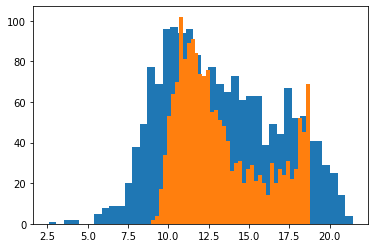

In [110]:
import matplotlib.pyplot as plt
from scipy.stats import boxcox
plt.hist(np.log1p(labels),bins=40)
plt.hist(np.log1p(preds),bins=40)

#plt.xscale('log')